In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
from tqdm import tqdm

In [3]:
import matplotlib.ticker as mticker

In [4]:
import xarray as xr

In [5]:
from matplotlib.dates import date2num, num2date
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.path as mpath

In [6]:
from matplotlib.gridspec import GridSpec

In [7]:
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

In [8]:
from plot_config import *

In [9]:
projection = ccrs.Stereographic(central_longitude=-40.0)

In [10]:
import os
salt_path = '/sciserver/filedb12-01/ocean/wenrui_temp/centerS_normalNmean/'
salt_path = '/export/scratch/wjiang33/cooked/centerS_normalNmean/'
# particle_path = '/sciserver/filedb04-01/ocean/wenrui_temp/particle_file/freshM/table'
# os.listdir(salt_path)

In [11]:
ds = xr.open_zarr(salt_path)
# tb = xr.open_zarr(particle_path)

/home/wjiang33/miniconda3/envs/bubblebath/lib/python3.12/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.38.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


In [12]:
just_for_time = '/sciserver/filedb10-01/ocean/wenrui_temp/vol_budget'

rtime = np.array(xr.open_zarr(just_for_time).time)
ecco_grid = xr.open_zarr('~/ECCO_transport')
ds['time'] = rtime

In [13]:
ds['sp'] = ds['SALT'] - ds['smean']

In [14]:
izmax = 17
print(ecco_grid.Zl[izmax].values)
ds['map'] = -(ds['sp']*ecco_grid.drF)[:,:izmax].sum(dim = 'Z')/ecco_grid.Zl[izmax]

-207.16


In [15]:
xg = np.load('plotting_xg.npy')
yg = np.load('plotting_yg.npy')

In [16]:
fresh_lons = np.load('lineplotprep/fresh_lon.npy')
fresh_lats = np.load('lineplotprep/fresh_lat.npy')

In [17]:
salty_lons = np.load('lineplotprep/salty_lon.npy')
salty_lats = np.load('lineplotprep/salty_lat.npy')

In [18]:
fresh_times = np.array(ds['time'][fresh_idate:fresh_idate-3650:-1])
salty_times = np.array(ds['time'][salty_idate:salty_idate-3650:-1])

In [19]:
xrange = (-34,-10)
yrange = (47.5,65)
zrange = (-200,0)

lon_bool = np.logical_and(ds.XC[2]>xrange[0],ds.XC[2]<xrange[1])
lat_bool = np.logical_and(ds.YC[2]>yrange[0],ds.YC[2]<yrange[1])
dep_bool = np.logical_and(ds.Z>zrange[0],ds.Z<zrange[1])
pos_bool = np.logical_and(np.logical_and(lon_bool,lat_bool),dep_bool)

sp = ds['sp'][fresh_idate]
fresh_init_bool = (np.logical_and(sp[:,2]<-0.1,pos_bool)*ecco_grid.drF).sum(dim = 'Z')/VOLUME_EACH_fresh*1e6

In [20]:
sp = ds['sp'][salty_idate]
salty_init_bool = (np.logical_and(sp[:,2]>0.1,pos_bool)*ecco_grid.drF).sum(dim = 'Z')/VOLUME_EACH_salty*1e6

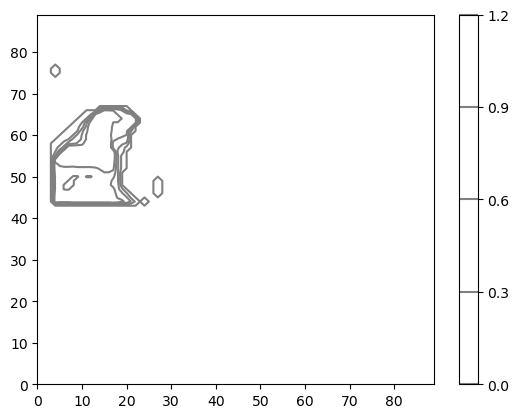

In [21]:
init_bool = fresh_init_bool
bins = 0.3
plt.contour(init_bool,np.arange(0,np.round(np.max(init_bool)/bins)*bins,bins),colors = 'grey')
plt.colorbar()

In [22]:
def pretty_stream_plot(
    lats,
    lons,
    times,
    init_bool,
    projection,
    axs = None,
    particle_bins=1,
    cmap = 'bwr',
    levels = [-0.15],
    extent = None,
    alpha = 1.0,
    itmax = 0,
    contour_colors = ['cadetblue','purple'],
    subplot_num = '(a)',
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
    save_as=False,
):
    spds = date2num(times)
    for i in [1,2,5,6,7,10,11]:
        pp = axs.pcolormesh(xg[i],yg[i],ecco_grid.Depth[i], 
                       cmap = depth_cmap, norm = depth_norm,transform = ccrs.PlateCarree(),
                            linewidth=0,rasterized=True)
        pp.set_edgecolor('face')
    axs.coastlines(color = 'w',resolution = '50m')
    if extent is not None:
        axs.set_extent(extent,crs = ccrs.PlateCarree())
    n = 20
    # aoi = mpath.Path(
    #     list(zip(np.linspace(extent[0],extent[1], n), np.full(n, extent[3]))) + \
    #     list(zip(np.full(n, extent[1]), np.linspace(extent[3], extent[2], n))) + \
    #     list(zip(np.linspace(extent[1], extent[0], n), np.full(n, extent[2]))) + \
    #     list(zip(np.full(n, extent[0]), np.linspace(extent[2], extent[3], n)))
    # )
    # axs.set_boundary(aoi, transform=ccrs.PlateCarree())
    # plt.tight_layout()
    # To speed up the computation, we transform the
    # latlon outside the for plotting for-loop.
    xx, yy, _ = projection.transform_points(ccrs.PlateCarree(), lons, lats).T

    xx = xx.T
    yy = yy.T
    
    norm = plt.Normalize(np.min(spds), np.max(spds))
    
    # color_of_time = cmap(norm(date2num(ds['time'][itmax].values)))
    # plt.plot(tb.lon[0],tb.lat[0],'o',markersize = 0.1, color = color_of_time, alpha = 0.1,transform = ccrs.PlateCarree())

    levels = levels
    xc = np.array(ecco_grid.XC[[2,6,10]]).ravel()
    yc = np.array(ecco_grid.YC[[2,6,10]]).ravel()
    values = []
    colors = []
    for offset,color_of_time in zip([183,730],contour_colors):
        time = ds['time'][itmax-offset].values
        values.append(date2num(time))
        colors.append(color_of_time)
        ct = axs.tricontour(xc,yc,
                            np.array(ds['map'][itmax-offset,[2,6,10]]).ravel(),
                            levels = levels,
                            colors = [color_of_time],linewidths = 1.3,
                            transform = ccrs.PlateCarree(),zorder = 5)
        axs.plot(fresh_lons[offset,::20],fresh_lats[offset,::20],'o',
                 color = color_of_time,transform = ccrs.PlateCarree(),
                 markersize = 0.7)
        # plt.clabel(ct, fmt= str(time)[:7],fontsize = 8)
        # plt.plot(tb.lon[offset,random_which],tb.lat[offset,random_which],'D',markersize = 5, c = color_of_time)
    # pcm = plt.pcolormesh(ecco_grid.XC[2],ecco_grid.YC[2],init_bool,
    #              color = 'none',hatch = 'OO',
    #              # hatch = 'OO',colors='none',levels = [0,1],
    #                # cmap = 'Blues',vmax = 5,vmin =0,
    #                transform = ccrs.PlateCarree(),zorder = 0)
    # pcm.set_hatch(np.array(init_bool)>0)
    # zm = np.ma.masked_less(init_bool, 0.3)
    # plt.pcolor(xg[2],yg[2],zm, hatch='....', alpha=0.,transform = ccrs.PlateCarree(),zorder = 10,rasterized = True)
    bins = 0.4
    plt.contour(ds.XC[2],ds.YC[2],init_bool,
                levels = np.arange(0,np.round(np.max(init_bool)/bins)*bins,bins),
                colors = 'grey',
                transform = ccrs.PlateCarree(),
                zorder = 10,
                linewidths = 0.5,)


    if True:
        for i in tqdm(range(0, lons.shape[1], particle_bins)):
            y = yy.T[i][1:]
            x = xx.T[i][1:]
            if np.max(x) - np.min(x) > 300:
                x[x < 0] += 360
            dydx = (0.5 * (spds[:-1] + spds[1:]))[1:]  # first derivative
    
            # Create a set of line segments so that we can color them individually
            # This creates the points as a N x 1 x 2 array so that we can stack points
            # together easily to get the segments. The segments array for line collection
            # needs to be (numlines) x (points per line) x 2 (for x and y)
            points = np.array([x, y]).T.reshape(-1, 1, 2)
    
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
            # Create a continuous norm to map from data points to colors
            lc = LineCollection(segments, cmap=cmap, norm=norm,lw = 0.01,alpha = alpha,zorder=1,rasterized = True)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(0.3)
            axs.add_collection(lc)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location = 'left',aspect = 30,shrink = 1)
    year0 = int(np.datetime_as_string(times[-1], unit='Y'))
    year1 = int(np.datetime_as_string(times[0], unit='Y'))
    labels = np.arange(year0, year1+1,2)
    if np.datetime64(str(labels[0]))<times[-1]:
        labels = labels[1:]
    date_ticks = [date2num(np.datetime64(str(label))) for label in labels]
    cbar.set_ticks(date_ticks)
    cbar.set_ticklabels(labels)
    cbar.set_label('Year',fontsize = 7)
    cbar.ax.text(1.05, 1.02, subplot_num, transform=cbar.ax.transAxes, ha="right", va="bottom",fontsize = 7)

    # Add a notch at a specific value with a given color
    for i,value in enumerate(values):
        cbar.ax.axhline(value, color=colors[i], linewidth=1, linestyle='-')
    axs.set_extent([-90,0,88,10],crs = ccrs.PlateCarree())
    gl = axs.gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--", linewidth=0.5)
    gl.xlocator = mticker.FixedLocator(np.arange(-8,4)*20)
    gl.y_inline = False
    gl.x_inline = False
    gl.xlabel_style = {"fontsize": 5}
    gl.ylabel_style = {"fontsize": 5}

In [23]:
extra_text = 'The spreads are enhanced 10 times'
xfill = {
    'fresh':(np.datetime64('2015-02-01'),np.datetime64('2015-03-01')),
    'salty':(np.datetime64('2006-05-01'),np.datetime64('2006-08-01')),
}

In [24]:
def create_line_plot(axs,case,duration,ylim = (-0.23,0.07)):
    pre = 'lineplotprep/'+case+'_'
    if duration == 'five':
        time_slice = slice(1824,None,-1)
    elif duration == 'ten':
        time_slice = slice(None,None,-1)
    else:
        raise ValueError('duration not precalculated')
    str_slc = str(time_slice)
    
    if case == 'salty':
        TOTAL_VOLUME,NUMBER_OF_PARTICLE,VOLUME_EACH,idate = TOTAL_VOLUME_salty,NUMBER_OF_PARTICLE_salty,VOLUME_EACH_salty,salty_idate
    if case == 'fresh':
        TOTAL_VOLUME,NUMBER_OF_PARTICLE,VOLUME_EACH,idate = TOTAL_VOLUME_fresh,NUMBER_OF_PARTICLE_fresh,VOLUME_EACH_fresh,fresh_idate
    mean = xr.open_zarr(pre+'mean'+str_slc)
    std = xr.open_zarr(pre+'std'+str_slc)
    xtime = rtime[idate:idate-len(mean.time):-1]
    
    handles = []
    labels = []
    for var in rhs_list:
        # print(var)
        a_mean = -mean[var][::-1]
        a_std = 10*std[var][::-1]/np.sqrt(NUMBER_OF_PARTICLE-1)
        print(var,float(a_mean[0]))
        mean_line, = axs.plot(xtime, a_mean, label=case_term_dic[var], color=color_dic[var])
        spread_area = axs.fill_between(xtime, a_mean - a_std, a_mean + a_std, alpha=0.3, label=case_term_dic[var], color=color_dic[var])
        handles.append((mean_line, spread_area))
        labels.append(case_term_dic[var])
    mean['tot'] = (mean['A']+mean['e_ua']+mean['E']+mean['dif_h']+mean['dif_v']+mean['I']+mean['F'])
    offset = float(mean['sf'][0])
    salt = np.diff(np.array([0]+list(mean['sl'].data)))
    to_explain = salt - offset
    error = to_explain + mean['tot']
    mean_line, = axs.plot(xtime, error[::-1], color=error_color)
    handles.append(mean_line)
    labels.append('Error')
    axs.set_ylabel('Cumulative Change (PSU)',fontsize = 7)
    ax2 = axs.twinx()
    ax2.set_ylabel('Salinity Anomaly (PSU)',fontsize = 7)
    ax2.tick_params('both',labelsize = 6)
    ax2.set_ylim(ylim[0] + offset, ylim[1] + offset)
    if case == 'salty':
        sal_color = salty_theme_color
    elif case == 'fresh':
        sal_color = fresh_theme_color
    salt_line, = axs.plot(xtime, salt[::-1]-offset,color = sal_color)
    print('salt',float(salt[-1]),offset)
    # handles.append(salt_line)
    # labels.append('Salinity Anomaly')
    # invisible_line, = plt.plot([],[],c = 'none')
    
    # ylim = axs.get_ylim()
    axs.fill_betweenx(ylim,[xfill[case][0]]*2,[xfill[case][1]]*2,**fill_betweenx_kwarg)
    axs.set_ylim(*ylim)
    axs.set_xlabel('Year',fontsize = 7)
    axs.tick_params(labelsize=6) 
    return labels,handles,salt_line

A 0.12932640410389307
F 0.04814764262966319
dif_v -0.055918508410875464
E 0.009459047357080145
dif_h 8.357923932646942e-05
e_ua -0.0018673700860662576
I 0.005620970841951449
salt 0.14989795328501998 0.0114077496758161


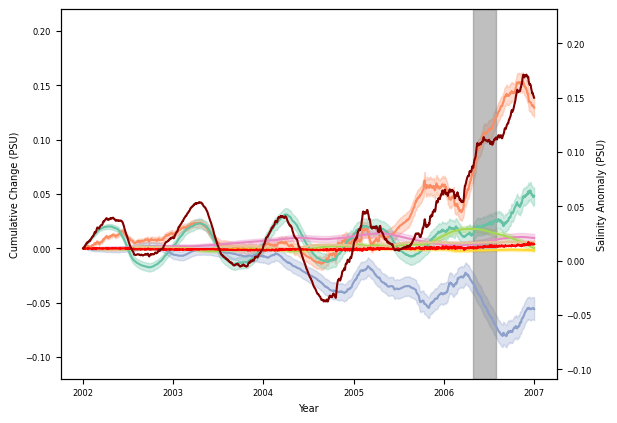

In [25]:
axs = plt.axes()
case = 'salty'
duration = 'five'
lb,hd,sl = create_line_plot(axs,case,duration,ylim = (-0.12,0.22))

A -0.19613034304642785
F -0.009294656864427493
dif_v 0.04245979294352936
E -0.014503843283281333
dif_h 0.030347688526499567
e_ua -0.0006457978300695635
I 0.0036585730485935598
salt -0.15416779098461575 -0.011512651981804256


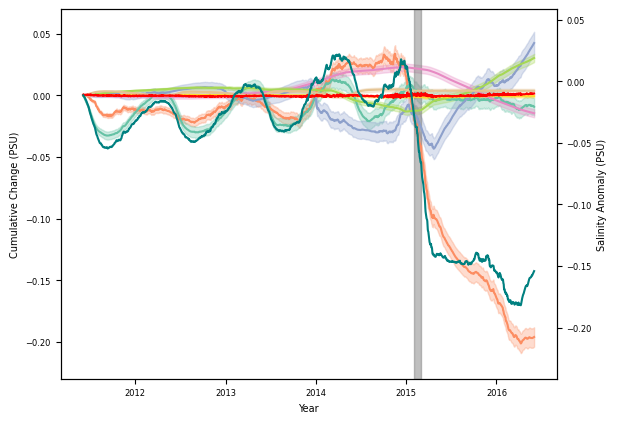

In [26]:
axs = plt.axes()
case = 'fresh'
duration = 'five'
lb,hd,sl = create_line_plot(axs,case,duration,)

In [27]:
extent = (-90, 10, 12, 60)

In [28]:
mm = 1/25.4

100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 36.09it/s]


A -0.19613034304642785
F -0.009294656864427493
dif_v 0.04245979294352936
E -0.014503843283281333
dif_h 0.030347688526499567
e_ua -0.0006457978300695635
I 0.0036585730485935598
salt -0.15416779098461575 -0.011512651981804256


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.67it/s]


A 0.12932640410389307
F 0.04814764262966319
dif_v -0.055918508410875464
E 0.009459047357080145
dif_h 8.357923932646942e-05
e_ua -0.0018673700860662576
I 0.005620970841951449
salt 0.14989795328501998 0.0114077496758161


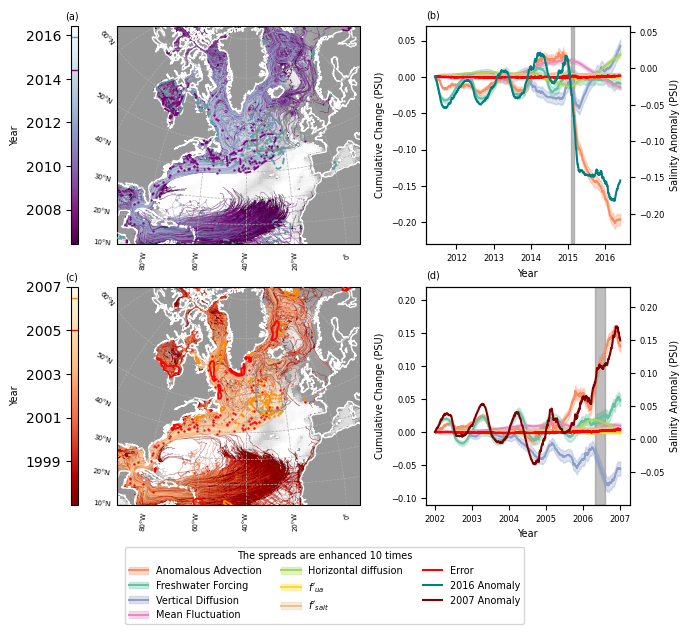

In [29]:
fig = plt.figure(figsize = (180*mm,165*mm))
gs = GridSpec(3,2,figure = fig,width_ratios = [1,0.52],height_ratios = [1,1,0.35])
axs = fig.add_subplot(gs[0,0], projection = projection)
pretty_stream_plot(
    fresh_lats,
    fresh_lons,
    fresh_times,
    fresh_init_bool,
    projection,
    axs = axs,
    cmap = fresh_time_cmap,
    extent = extent,
    alpha = 0.75,
    particle_bins=1,
    itmax = fresh_idate,
    subplot_num = '(a)',
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
    save_as=False,
)
axs.set_extent((-90,5, 12, 80),crs = ccrs.PlateCarree())
axs = fig.add_subplot(gs[0,1])
_,_,salt_line = create_line_plot(axs,'fresh','five')
axs.set_title('('+chr(97+1)+')',loc = 'left',fontsize = 7)
axs = fig.add_subplot(gs[1,0], projection = projection)
pretty_stream_plot(
    salty_lats,
    salty_lons,
    salty_times,
    salty_init_bool,
    projection,
    axs = axs,
    cmap = salty_time_cmap,
    extent = extent,
    alpha = 0.75,
    particle_bins=1,
    itmax = salty_idate,
    levels = [0.15],
    contour_colors = ['darkorange','red'],
    subplot_num = '(c)',
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
    save_as=False,
)
axs.set_extent((-90, 5, 12, 80),crs = ccrs.PlateCarree())
axs = fig.add_subplot(gs[1,1])
labels,handles,salt_line2 = create_line_plot(axs,'salty','five',ylim = (-0.11,0.22))
handles.extend([salt_line,salt_line2])
labels.extend(['2016 Anomaly','2007 Anomaly'])
axs.set_title('('+chr(97+3)+')',loc = 'left',fontsize = 7)
ax_legend = fig.add_subplot(gs[2,:])
ax_legend.axis('off')  # Hide this axes
legend = ax_legend.legend(handles,labels,fontsize = 7,loc = 'center',ncol = 3)
legend.set_title(extra_text)
plt.setp(legend.get_title(),fontsize=7)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25,wspace = 0.05)
plt.savefig('ng_fig1.pdf', format="pdf",dpi = 300)

In [30]:
# fig = plt.figure(figsize = (180*mm,165*mm))
# gs = GridSpec(3,2,figure = fig,height_ratios = [1,0.75,0.5])
# axs = fig.add_subplot(gs[0,0], projection = projection)
# pretty_stream_plot(
#     fresh_lats,
#     fresh_lons,
#     fresh_times,
#     fresh_init_bool,
#     projection,
#     axs = axs,
#     cmap = fresh_time_cmap,
#     extent = extent,
#     alpha = 0.75,
#     particle_bins=1,
#     itmax = fresh_idate,
#     subplot_num = '(a)',
#     # bins=5,
#     # north=1000,
#     # south=-1000,
#     # plot_lines=True,
#     save_as=False,
# )

# axs = fig.add_subplot(gs[0,1], projection = projection)
# pretty_stream_plot(
#     salty_lats,
#     salty_lons,
#     salty_times,
#     salty_init_bool,
#     projection,
#     axs = axs,
#     cmap = salty_time_cmap,
#     extent = extent,
#     alpha = 0.75,
#     particle_bins=1,
#     itmax = salty_idate,
#     levels = [0.15],
#     contour_colors = ['darkorange','red'],
#     subplot_num = '(c)',
#     # bins=5,
#     # north=1000,
#     # south=-1000,
#     # plot_lines=True,
#     save_as=False,
# )
# axs = fig.add_subplot(gs[1,0])
# _,_,salt_line = create_line_plot(axs,'fresh','five')
# axs.set_title('('+chr(97+1)+')',loc = 'left',fontsize = 7)

# axs = fig.add_subplot(gs[1,1])
# labels,handles,salt_line2 = create_line_plot(axs,'salty','five',ylim = (-0.11,0.22))
# handles.extend([salt_line,salt_line2])
# labels.extend(['2016 Anomaly','2007 Anomaly'])
# axs.set_title('('+chr(97+3)+')',loc = 'left',fontsize = 7)
# ax_legend = fig.add_subplot(gs[2,:])
# ax_legend.axis('off')  # Hide this axes
# legend = ax_legend.legend(handles,labels,fontsize = 7,loc = 'center',ncol = 3)
# legend.set_title(extra_text)
# plt.setp(legend.get_title(),fontsize=7)
# plt.tight_layout()
# # plt.subplots_adjust(hspace = 0.25,wspace = 0)
# plt.savefig('ng_fig1.pdf', format="pdf",dpi = 300)

A -0.1941118574396773
F -0.02508679742554227
dif_v 0.03394658290793942
E -0.018972538310225964
dif_h 0.036825866359635126
e_ua 0.00032855983797385385
I 0.007315328179859777
salt -0.1541677909846726 0.008523976514774345
A 0.14817286701373522
F 0.04635773561784862
dif_v -0.0668205905029988
E 0.01511779742858697
dif_h -0.0031759778698129655
e_ua -0.002255474586605091
I 0.008211825788440666
salt 0.14989795328501998 0.006369468123218331


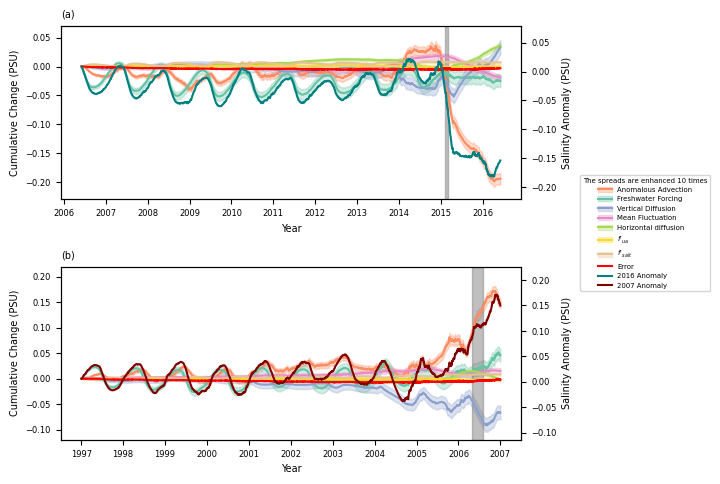

In [31]:
fig = plt.figure(figsize = (180*mm,120*mm),constrained_layout = True)
gs = GridSpec(2,2,figure = fig,width_ratios = [1,0.2])
axs = fig.add_subplot(gs[0,0])
_,_,salt_line = create_line_plot(axs,'fresh','ten')
axs.set_title('('+chr(97)+')',loc = 'left',fontsize = 7)

axs = fig.add_subplot(gs[1,0])
labels,handles,salt_line2 = create_line_plot(axs,'salty','ten',ylim = (-0.12,0.22))
axs.set_title('('+chr(97+1)+')',loc = 'left',fontsize = 7)

handles.extend([salt_line,salt_line2])
labels.extend(['2016 Anomaly','2007 Anomaly'])

ax_legend = fig.add_subplot(gs[:,1])
ax_legend.axis('off')  # Hide this axes
legend = ax_legend.legend(handles,labels,fontsize = 5,loc = 'center',ncol = 1)
legend.set_title(extra_text)
plt.setp(legend.get_title(),fontsize=5)

plt.savefig('ten_year_line.pdf', format="pdf",dpi = 300)

In [32]:
# ax = plt.axes(projection = ccrs.Stereographic(central_longitude=-40.0,central_latitude = 60))
# ax.coastlines()
# ax.set_extent([-90,0,88,10],crs = ccrs.PlateCarree())
# gl = ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, linestyle="--", linewidth=0.5)
# gl.xlocator = mticker.FixedLocator(np.arange(-8,4)*20)

# gl.x_inline = False
# gl.y_inline = False

# plt.show()